In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Custom regression function that returns the minimum value from both y_1 and y_2 for each leaf
def custom_regression_func(leaf_targets, loss_type='squared'):
    endpoints = np.unique(leaf_targets[np.isfinite(leaf_targets)])
    y_min, y_max = leaf_targets[:, 0], leaf_targets[:, 1]
    lower_loss = np.maximum(0, y_min[:, None] - endpoints)  # Loss when mu is below y_min
    upper_loss = np.maximum(0, endpoints - y_max[:, None])  # Loss when mu is above y_max
    if loss_type == 'squared':
        lower_loss = lower_loss ** 2
        upper_loss = upper_loss ** 2
    losses = np.sum(lower_loss + upper_loss, axis=0)
    min_loss_idx = np.argmin(losses)
    mu = endpoints[min_loss_idx]
    return mu

In [3]:
class CustomDecisionTreeRegressor(DecisionTreeRegressor):
    def __init__(self, custom_regression_func=None, criterion='squared_error', splitter='best', max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None,
                 random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0):
        # Initialize the parent class with the parameters passed to it
        super().__init__(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split,
                         min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                         max_features=max_features, random_state=random_state, max_leaf_nodes=max_leaf_nodes,
                         min_impurity_decrease=min_impurity_decrease, ccp_alpha=ccp_alpha)
        
        # Set the custom regression function
        self.custom_regression_func = custom_regression_func
        self.y_train = None  # This will store the target values after fitting
    
    def fit(self, X, y):
        # Fit the model and store the target values
        super().fit(X, y)
        self.y_train = y  # Store the target values (this is now accessible in predict)
        return self

    def predict(self, X):
        # Get the leaf indices for each sample
        leaf_indices = self.apply(X)
        
        # Now for each leaf, we apply the custom regression function
        predictions = np.zeros((X.shape[0], self.y_train.shape[1]))  # Assuming multiple target variables
        
        # Loop over each leaf and apply the custom regression function
        for leaf_index in np.unique(leaf_indices):
            leaf_targets = self.y_train[leaf_indices == leaf_index]
            predictions[leaf_indices == leaf_index] = self.custom_regression_func(leaf_targets)
        
        return predictions

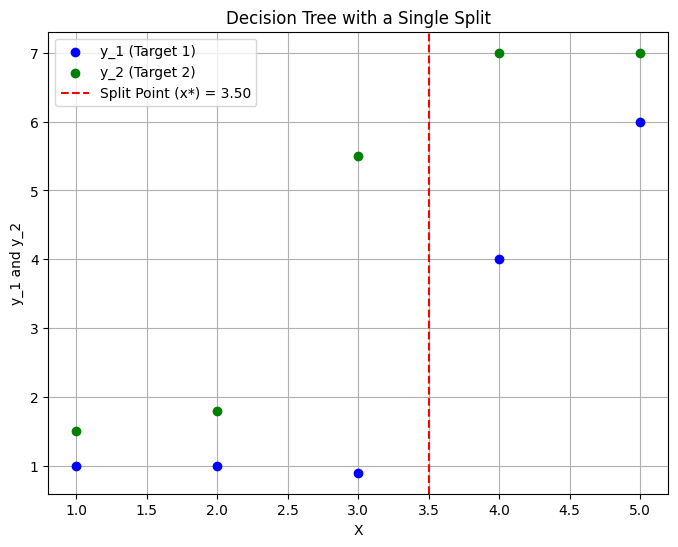

In [4]:
# Generate 5 instances with a single feature (X) and two target variables (y_1, y_2)
X = np.array([[1], [2], [3], [4], [5]])  # 5 instances with 1 feature
y = np.array([[1, 1.5], [1, 1.8], [0.9, 5.5], [4, 7], [6, 7]])  # Two targets per instance (y_1, y_2)

# Create an instance of the custom regressor with the custom regression function
regressor = CustomDecisionTreeRegressor(custom_regression_func=custom_regression_func, max_depth=1)

# Fit the model to the data
regressor.fit(X, y)

# Get the split point (this can be accessed after fitting, since we are considering only one split)
split_point = regressor.tree_.threshold[0]  # The split threshold for the first node

# Predict using the model
predictions = regressor.predict(X)

# Plot the data
plt.figure(figsize=(8, 6))

# Plot the instances
plt.scatter(X, y[:, 0], color='blue', label='y_1 (Target 1)', zorder=5)
plt.scatter(X, y[:, 1], color='green', label='y_2 (Target 2)', zorder=5)

# Plot the split point
plt.axvline(x=split_point, color='red', linestyle='--', label=f'Split Point (x*) = {split_point:.2f}')

# Plot settings
plt.title('Decision Tree with a Single Split')
plt.xlabel('X')
plt.ylabel('y_1 and y_2')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [5]:
predictions

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [6., 6.],
       [6., 6.]])